# Exploration

EDA of the features and target

# Goal

Find patterns on the features for target

# Plan

Checklist what will be done on the notebook :

    [*] Get Data
    [*] Data Preparations
    [*] Features Summary
    [*] Features correlations to Target
    [*] Simple Exploration
    [*] Feature engineerning



In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer


In [3]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']

if os.name == 'posix' :
    PATH_MODEL = config['path']['artifact']+os.getcwd().split('/')[-1]+'/'
else:
    PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'

PATH_UDF = config['path']['udf']

In [4]:
# %matplotlib inline

## Get Data

In [5]:
raw_trn = pd.read_csv(PATH_INTERIM+'data_trn_iter3.csv', index_col=0)

In [6]:
raw_trn.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,pdays,previous,poutcome,y,ids
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,-1.0,0.0,unknown,no,0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,-1.0,0.0,unknown,no,2
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,-1.0,0.0,unknown,no,3
5,35.0,management,married,tertiary,no,231.0,yes,no,unknown,5.0,may,139.0,-1.0,0.0,unknown,no,5
6,28.0,management,single,tertiary,no,447.0,yes,yes,unknown,5.0,may,217.0,-1.0,0.0,unknown,no,6


# Missing Value

<Figure size 720x432 with 0 Axes>

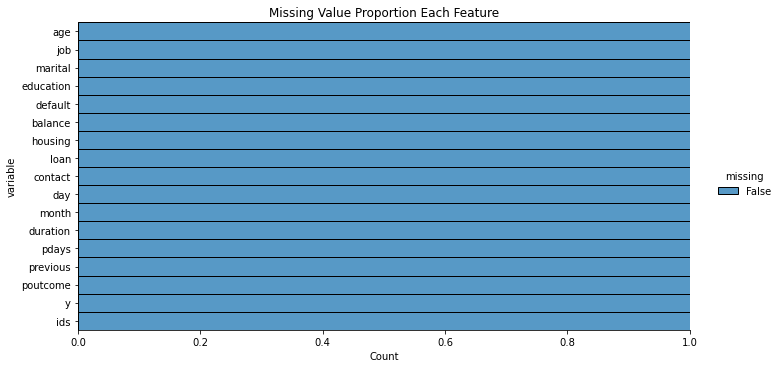

In [7]:
plt.figure(figsize=(10,6))
sns.displot(
    data=raw_trn.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=2
)
plt.title("Missing Value Proportion Each Feature");


there is no missing value in data 

# EDA

# Numerical

In [8]:

colors = sns.color_palette("Set2")
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [9]:
#Plot Histogram,KDE,Boxplot
def num_eda(data,feature,target,bins ):
    df_set_pos = data[data[target] == "yes"].drop(target,axis = 1)
    df_set_neg = data[data[target] == "no"].drop(target,axis = 1)
    #plot numerical data (Classification Task)
    fig, axes = plt.subplots(2,2,figsize = (18,6))

    ax1 = sns.histplot(x = feature,data = data,ax = axes[0,0],bins = bins,kde = True,edgecolor = "k",color = colors[4])
    ax1.grid(linestyle='--', linewidth=0.1, color=colors[7])
    ax1.set_title(f"{feature} Distribution")
    
    ax2 = sns.kdeplot(x = feature,data = df_set_pos,ax = axes[0,1],label ="yes",color = colors[2],)
    ax2_1 = sns.kdeplot(x = feature,data = df_set_neg,ax = axes[0,1],label = "no",color = colors[1],)
    ax2.grid(linestyle='--', linewidth=0.1, color=colors[7])
    ax2.set_title(f"{feature} Distribution by Target Class")
    ax2.legend()
    
    ax3 = sns.boxplot(x = feature,data = data,ax = axes[1,0],color = colors[4])
    ax3.grid(linestyle='--', linewidth=0.5, color=colors[7])
    
    ax4 = sns.boxplot(x = feature,y = target,data = data,ax = axes[1,1],orient = "h",palette = [colors[1],colors[2]])
    ax4.grid(linestyle='--', linewidth=0.1, color=colors[7])

## age 

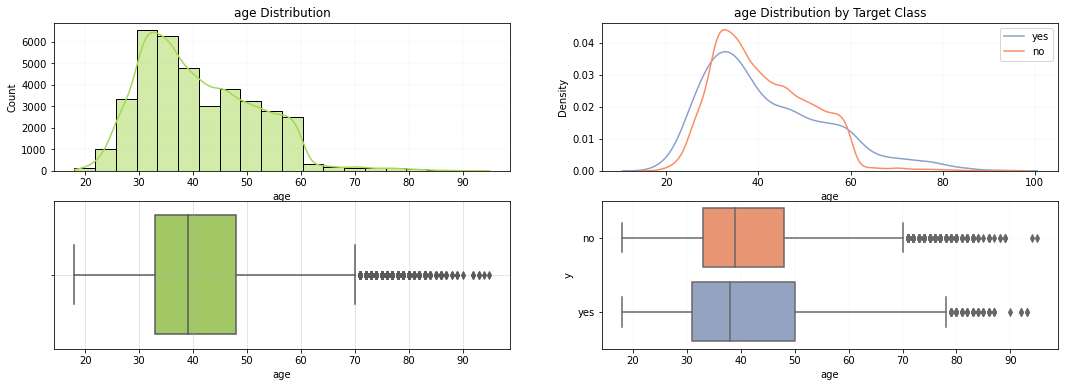

In [10]:
num_eda(raw_trn,"age","y",bins = 20)

pelanggan berkisar diantara umur 20 - 90 tahun, namun kebanykan pelanggan ada diantara umur 20-60 tahun, Untuk pelanggan yang berumur 70 tahun keatas, cenderung memiliki kesuksesan kampanye yang sedikit lebih tinggi. 

## balance

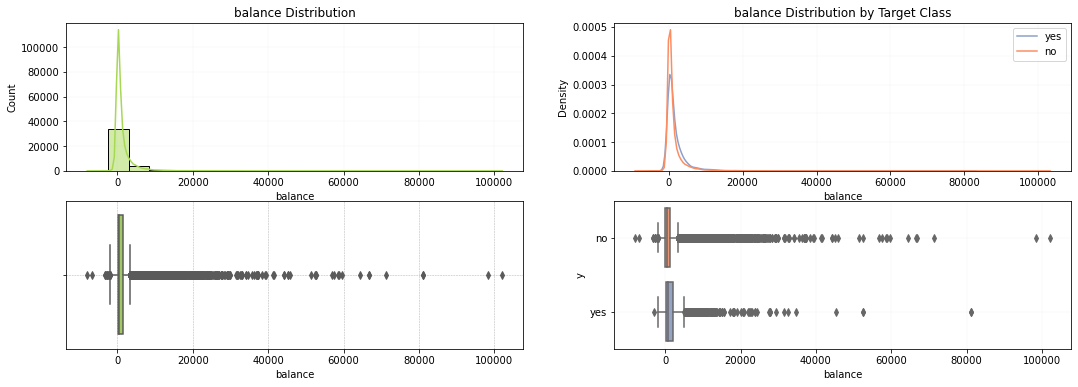

In [11]:
num_eda(raw_trn,"balance","y",bins = 20)

terdapat nilai balance yang minus, oleh karena itu kita akan mengambil nilai balance yang lebih dari 0

In [12]:
#filter balance > 0
raw_trn = raw_trn[raw_trn["balance"] >= 0]

## day

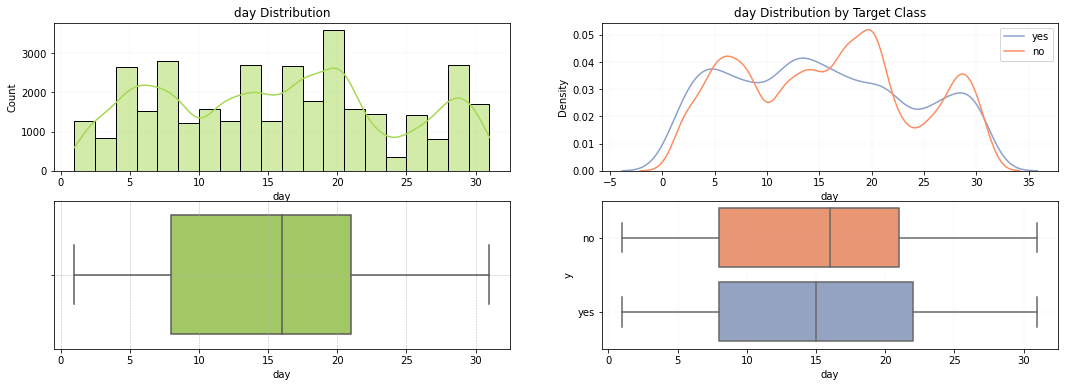

In [13]:
num_eda(raw_trn,"day","y",bins = 20)

pada grafik kde, terdapat nilai turun pada kampanye yang sukses, dan naik pada kampanye yang gagal, yakni pada tanggal 15-23.

## duration

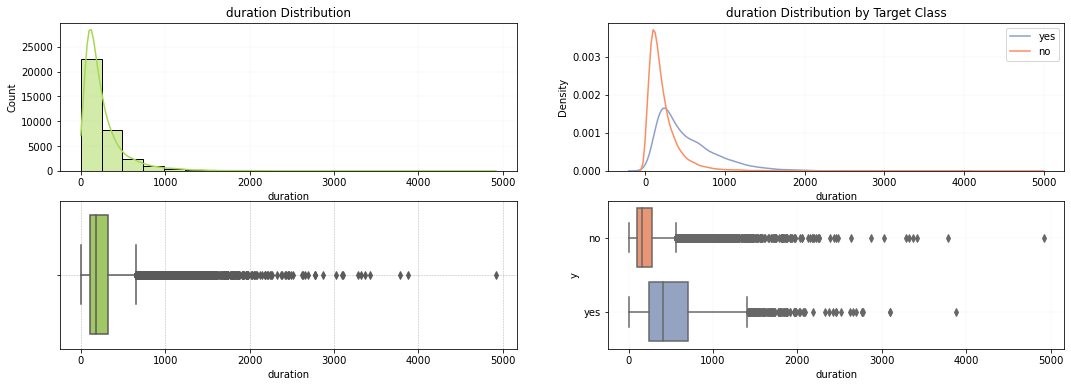

In [14]:
num_eda(raw_trn ,"duration","y",bins = 20)

Pelanggan yang memiliki durasi panggilan lebih lama cenderung memiliki peluang kampanye sukses yang tinggi. <br>
terdapat nilai outlier pada data, nantinya akan kita eliminasi 

## previous

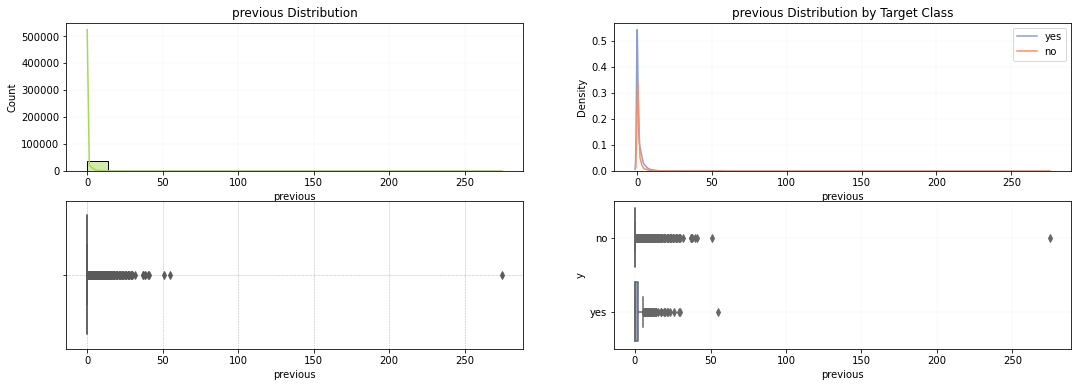

In [15]:
num_eda(raw_trn,"previous","y",bins = 20)

In [16]:
raw_trn = raw_trn[raw_trn.previous < 250]

## pdays

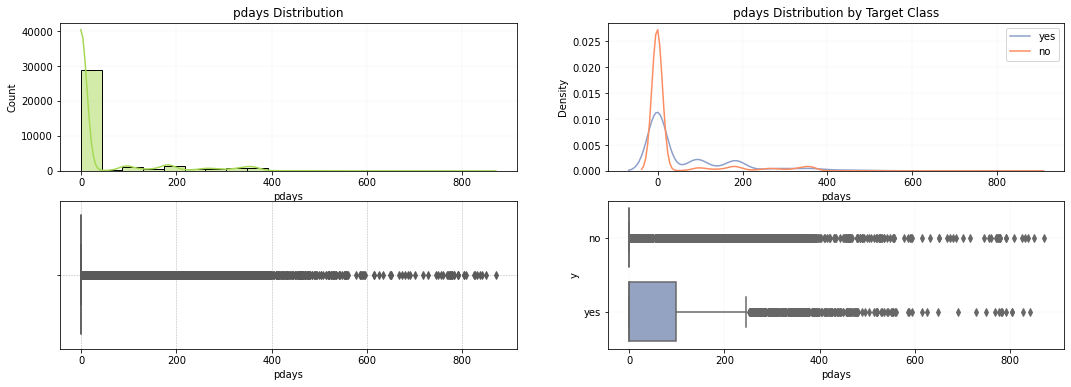

In [17]:
num_eda(raw_trn,"pdays","y",bins = 20)

kita bisa membuat fitur baru dari kolom ini, misalnya pyears dan pmonth, adalah konversi dari hari ke tahun atau bulan, selain itu kita bisa membuat fitur untuk mengetahui apakah pelanggan tersebut baru dihubungi atau tidak dari fitur ini.

### hal yang sudah dilakukan pada Numerical Columns :

1.  menghapus nilai `balance` yang < 0 
2.  meghapus nilai outlier pada kolom `previous` ( > 250)

### hal yang harus dilakukan pada Numerical Columns :
1.  Impute missing values
2.  Transformasi data 

### hal yang bisa dilakukan untuk feature engineering:
1.  membuat kolom baru bernama `new`, bernilai yes jika pdays = -1 dan no jika lainnya


## Categorical Column

In [18]:
#plot categorical Data (classification Task)
def cat_eda(data,feature,target):
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    
    ax1 = sns.countplot(x=feature, data=data, ax=axes[0],color = colors[4],edgecolor = colors[7])
    ax1.bar_label(ax1.containers[0])
    ax1.set_title(f"{feature} Distribution")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax2 = sns.countplot(x = feature,hue = target, data = data,ax = axes[1],palette = [colors[1],colors[2]],edgecolor = colors[7])
    ax2.set_title(f"{feature} Distribution with target")
    #set xticks 90
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.bar_label(ax2.containers[0])
    ax2.bar_label(ax2.containers[1])

## Job, Marital, Education, Poutcome, Month, Contact

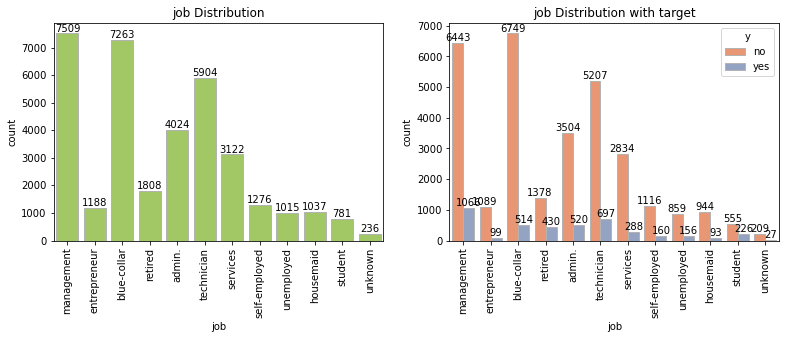

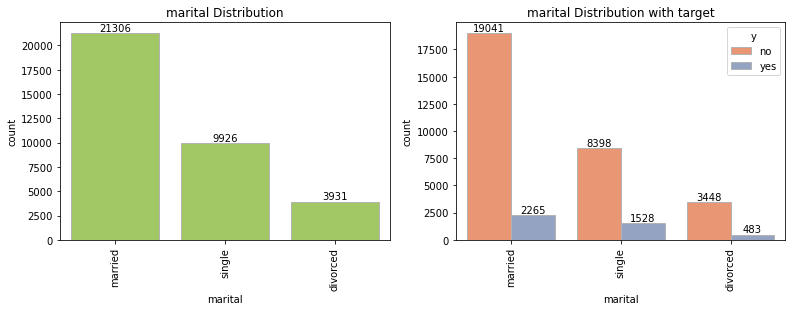

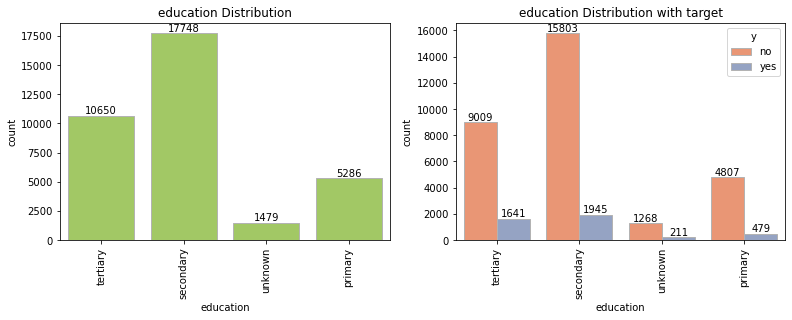

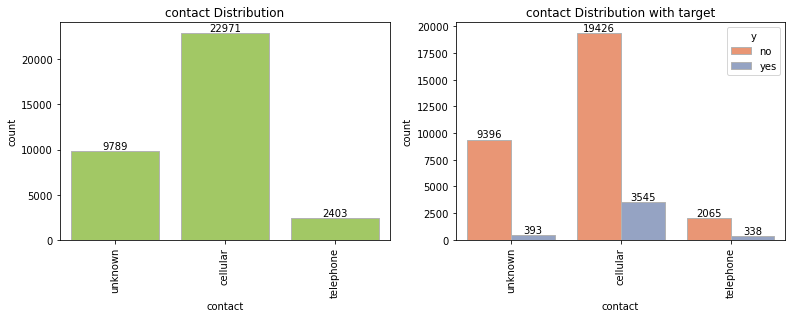

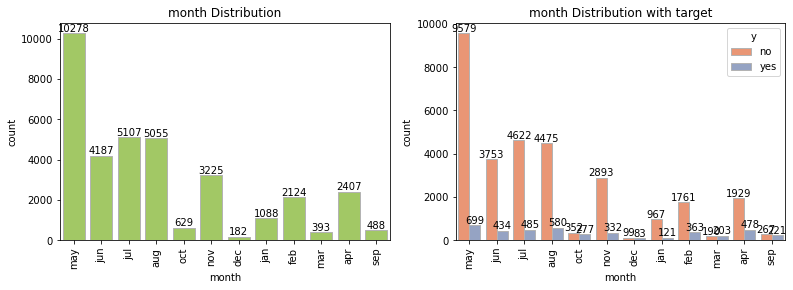

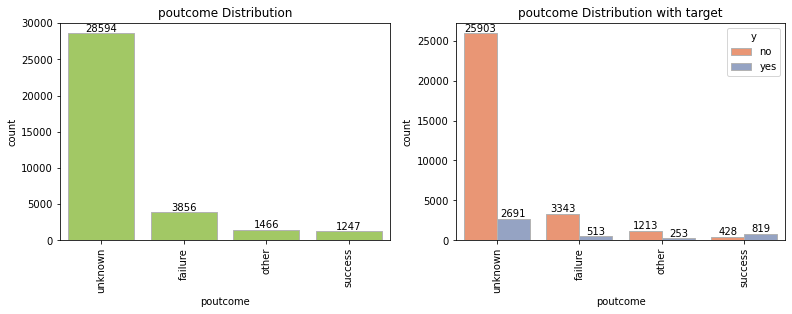

In [19]:
col1 = ["job","marital","education","contact","month","poutcome"]
for col in col1:
    cat_eda(raw_trn,col,"y")
    

mungkin kita akan membuang kolom poutcome karena niali unknwon memiliki jumlah yang sangat berbeda jauh dengan jumlah nilai lainnya.

## default, housing, loan

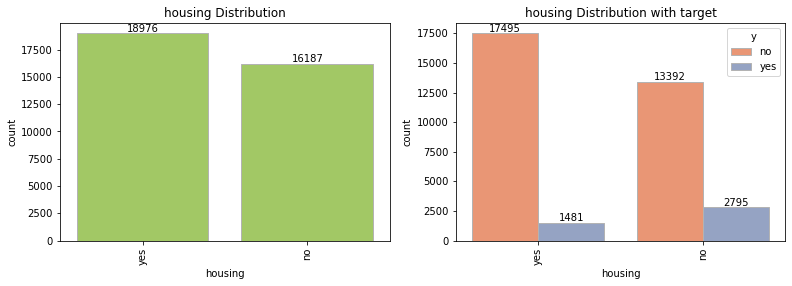

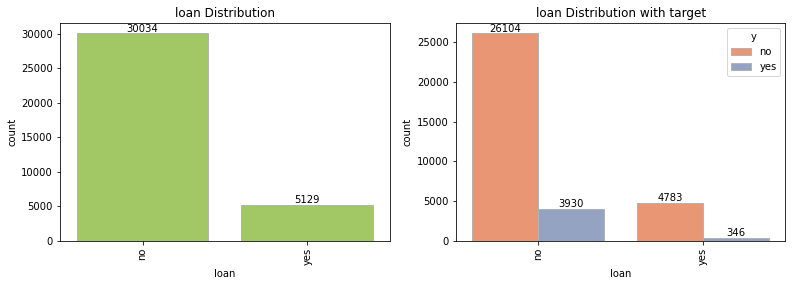

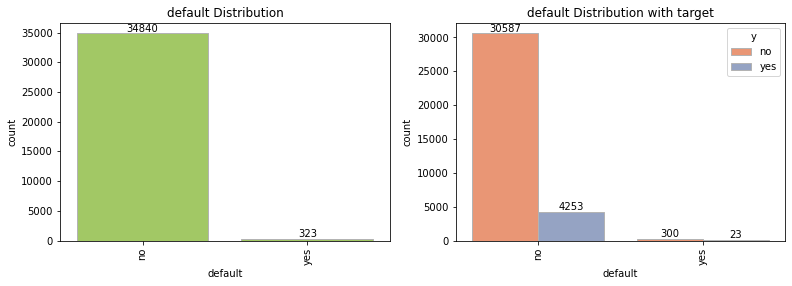

In [20]:
col2 = ["housing","loan","default"]
for col in col2:
    cat_eda(raw_trn,col,"y")

kita akan membuat kolom baru dari ketiga  kolom ini, yakni count_col , jumlah dari nilai yes dari ketiga kolom ini.

In [21]:
raw_trn.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,pdays,previous,poutcome,y,ids
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,-1.0,0.0,unknown,no,0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,-1.0,0.0,unknown,no,2
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,-1.0,0.0,unknown,no,3
5,35.0,management,married,tertiary,no,231.0,yes,no,unknown,5.0,may,139.0,-1.0,0.0,unknown,no,5
6,28.0,management,single,tertiary,no,447.0,yes,yes,unknown,5.0,may,217.0,-1.0,0.0,unknown,no,6


# Feature Engineering

In [22]:
X = raw_trn.drop(["y","ids"],axis = 1)
y = raw_trn["y"]

### Count_col Pipeline

In [23]:
## fungsi untuk menjumlahkan nilai yes
class count_yes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation
        data = X.copy()
        data["count_yes"] = (data[["default","loan","housing"]] == "yes").sum(axis = 1)
        return data

count_yes_obj = count_yes()

### is_new pipeline

In [24]:
## fungsi untuk membuat kolom pyears dan pmonth
class is_new(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation
        data = X.copy()
        data["is_new"] = (data["pdays"] == -1)
        return data

is_new_obj = is_new()

# Preprocessor Pipeline

Untuk kolom numerikal :
1. Imputasi nilai yang hilang dengan median
2. Transofrmasi kolom menggunakan yeo-johnson dan standarisasi

Untuk kolom kategorikal :
1. imputasi nilai yang hilang dengan nilai yang paling sering muncul (modus)
2. Ordinal Encoder sebagai pengganti label encoder

In [25]:
def prep_pipeline(X_train,numerical_columns = "default",categorical_columns = "default"):
    if numerical_columns == "default":
        numerical_columns = X_train.select_dtypes(include = ["float64"]).columns

    if categorical_columns == "default": 
        categorical_columns = X_train.select_dtypes(include = ["object"]).columns  
        
    numeric_transformer = Pipeline(steps = [
        ("impute", SimpleImputer(strategy = "median")),
        ("Transform",PowerTransformer())
    ])

    categorical_transformer = Pipeline(steps=[
        ("impute",SimpleImputer(strategy="most_frequent")),
        ("encoder",OrdinalEncoder())
    ])

    preprocessor = ColumnTransformer(transformers = [
        ("numerical",numeric_transformer,numerical_columns),
        ("categorical",categorical_transformer,categorical_columns)
    ])
    return preprocessor


In [26]:
num_columns = list(X.select_dtypes(include=["float64"]).columns) + ["count_yes"]
cat_columns = list(X.select_dtypes(include=["object"]).columns) + ["is_new"]

preprocessor_fe = prep_pipeline(X,numerical_columns = num_columns,categorical_columns = cat_columns)
preprocessor = prep_pipeline(X)

### Konfigurasi pipeline dengan FE

In [27]:
pipeline_with_fe = Pipeline([
    ("count_yes",count_yes()),
    ("is_new",is_new()),
    ("preprocessor",preprocessor_fe),
    ])

In [28]:
pipeline_with_fe

Pipeline(steps=[('count_yes', count_yes()), ('is_new', is_new()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Transform',
                                                                   PowerTransformer())]),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'pdays',
                                                   'previous', 'count_yes']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
            

In [29]:
joblib.dump(pipeline_with_fe,PATH_MODEL+"pipeline_with_fe.pkl")

['../../artifacts/iteration_3/pipeline_with_fe.pkl']

#### Konfigurasi pipeline tanpa FE

In [30]:
pipeline_base = Pipeline([
    ("preprocessor",preprocessor),
    ])

In [31]:
pipeline_base

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Transform',
                                                                   PowerTransformer())]),
                                                  Index(['age', 'balance', 'day', 'duration', 'pdays', 'previous'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
    

In [32]:
joblib.dump(pipeline_base,PATH_MODEL + "pipeline_base.pkl")

['../../artifacts/iteration_3/pipeline_base.pkl']

# Export Data

In [32]:
raw_trn.to_csv(PATH_PROCESSED + "prep_iter3.csv") 